# 0. Imports

## 0.1. Helper Functions

In [55]:
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import datetime
from scipy import stats as ss

In [2]:
#plt.rcParams['figure.figsize'] = [18, 6]
plt.rcParams['font.size'] = 8

## 0.2. Loading Data

In [3]:
df_sales_raw = pd.read_csv('../datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../datasets/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left',on='Store')

In [4]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1. Descrição do Dados

In [5]:
df1 = df_raw.copy()

df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# Função para colocar underscore para separar palavras
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))           # O map passa os valores de cols_old para a função snakecase

df1.columns = cols_new

## 1.2. Data Dimension

In [7]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 1017209
Number of columns: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fill out NA

In [10]:
#competition_distance - substituir os valores faltantes por distâncias muito grandes, indicando que não há competidores próximos
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if pd.isna(x)==True else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if pd.isna(x['competition_open_since_month'])==True
                                                                          else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if pd.isna(x['competition_open_since_year'])==True
                                                                          else x['competition_open_since_year'], axis=1)
                 
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if pd.isna(x['promo2_since_week'])==True
                                                                          else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if pd.isna(x['promo2_since_year'])==True
                                                                          else x['promo2_since_year'], axis=1)
           
#promo_interval
month_map = {1: 'Jan',
             2: 'Feb',
             3: 'Mar',
             4: 'Apr',
             5: 'May',
             6: 'Jun',
             7: 'Jul',
             8: 'Aug',
             9: 'Sep',
             10: 'Oct',
             11: 'Nov',
             12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0
                                                   else 1 if x['month_map'] in x['promo_interval'].split(',')
                                                   else 0, axis=1)

## 1.6. Change Types

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistical

In [12]:
# Split dataframe into numerical and categorical attributes
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [13]:
metrics = num_attributes.describe().T
metrics['median'] = num_attributes.median()
metrics['range'] = metrics['max'] - metrics['min']
metrics['skew'] = num_attributes.skew()
metrics['kurtosis'] = num_attributes.kurtosis()
metrics

,count,mean,std,min,25%,50%,75%,max,median,range,skew,kurtosis
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0,558.0,1114.0,-0.000955,-1.200524
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0,4.0,6.0,0.001593,-1.246873
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0,5744.0,41551.0,0.641460,1.778375
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0,609.0,7388.0,1.598650,7.091773
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.758045,1.090723
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.487838,-1.762018
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.677842,0.815154
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0,2330.0,199980.0,10.242344,147.789712
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0,7.0,11.0,-0.042076,-1.232607
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0,2012.0,115.0,-7.235657,124.071304


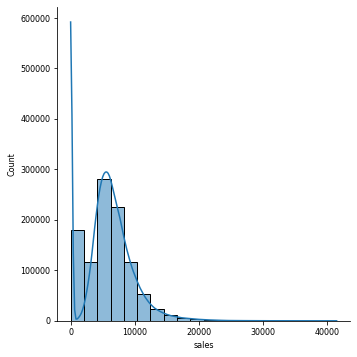

In [14]:
sns.displot(df1['sales'], kde=True, bins=20)

### 1.7.1. Categorical Attributes

In [15]:
cat_attributes.nunique()

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

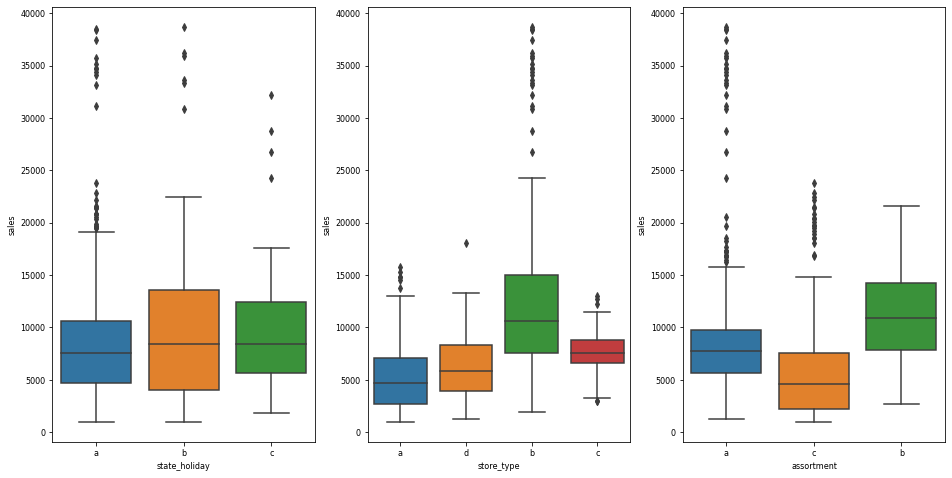

In [16]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(16,8))
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2. Feature Engineering

In [17]:
df2 = df1.copy()

## 2.1. Mapa mental de hipóteses

Hipóteses são apostas:
* Lojas de MAIOR porte deveriam vender MAIS
* Lojas com MAIOR sortimento deveriam vender MAIS
* Lojas com MAIS competidores perto deveriam vender MENOS

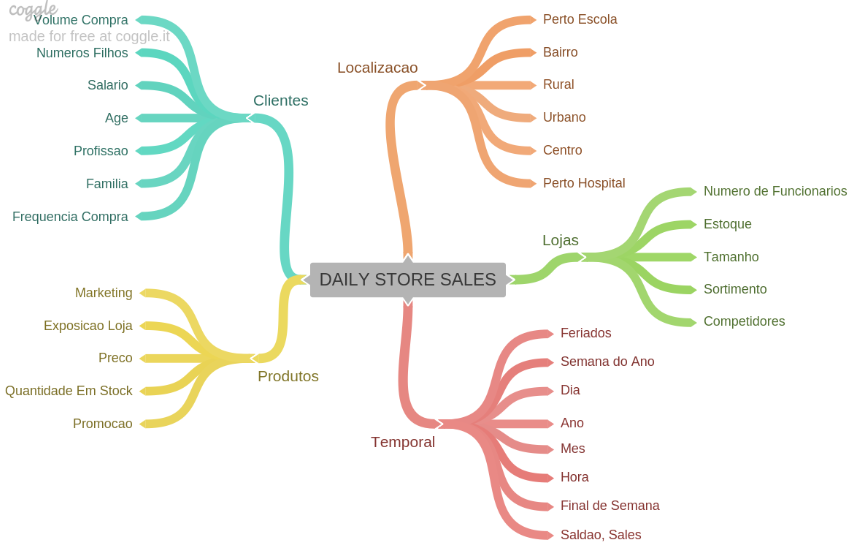

## 2.2. Criação das hipóteses

### 2.2.1. Hipóteses Lojas

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque maior deveriam vendem mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

### 2.2.2. Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoem mais produtos na vitrine deveriam vender mais.

**3.** Lojas com menores preços deveriam vender mais.

**4.** Lojas com preços menores por mais tempo deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2.4. Lista Final de Hipóteses

Baseando-se nos dados disponíveis, fazer uma lista possível de hipóteses:

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.
 
**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [18]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of the year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).dt.days.astype(int)

# primo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1','%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).dt.days.astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3. Filtragem de Variáveis

In [19]:
df3 = df2.copy()

In [20]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.1. Filtragem das Linhas

In [21]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas

In [22]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop,axis=1)

# 4. Análise Exploratória dos Dados

In [23]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response variable

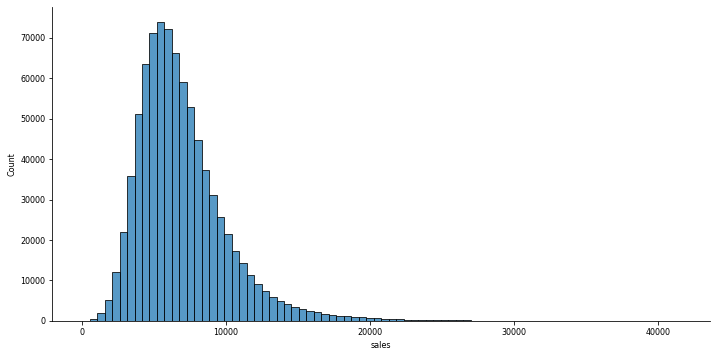

In [24]:
sns.displot(df4['sales'], bins=80, height=5, aspect=2)

### 4.1.2. Numerical variable

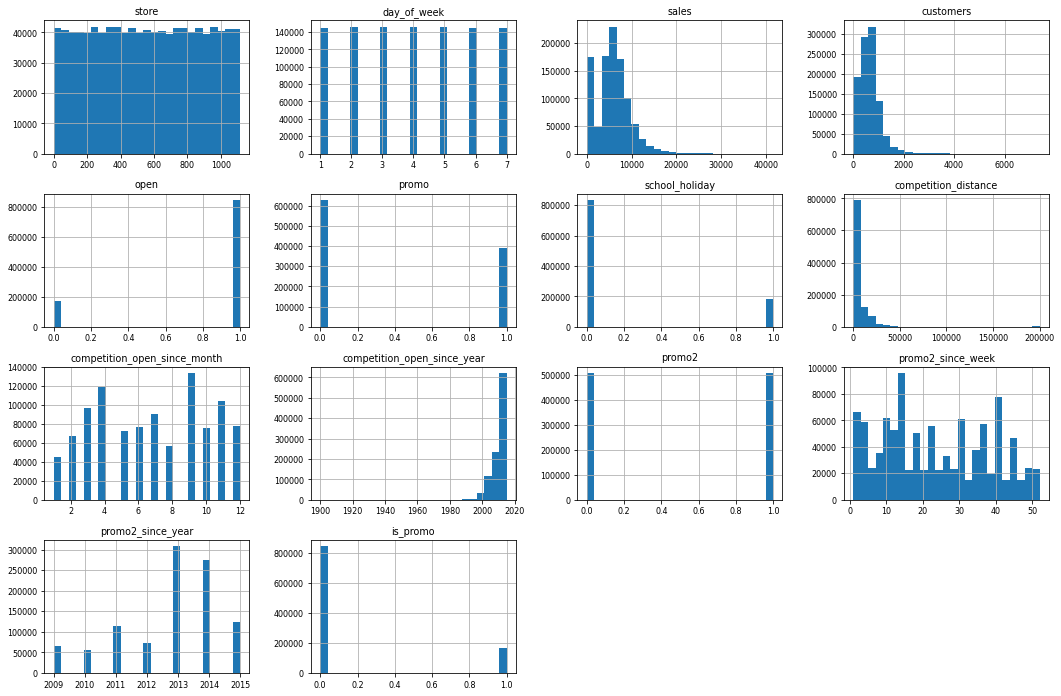

In [25]:
num_attributes.hist(bins=25, figsize=(18,12));
# Analisar os comportamentos das variáveis. Ver se ela "conta uma história".
# Ex.: day_of_week mostra que as vendas são praticamente iguais independente do dia. Ela sozinha não diz muita coisa

### 4.1.3. Categorical variable

In [26]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

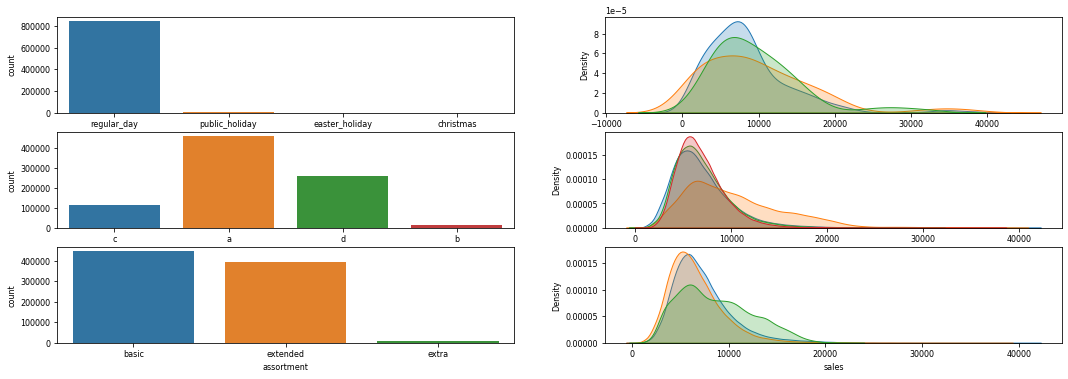

In [27]:
# state_holiday
plt.subplot(3, 2, 1)
lines = df4['state_holiday'] != 'regular_holiday'
df4_aux = df4.loc[lines, ['state_holiday']].reset_index(drop=True)
sns.countplot(df4_aux, x='state_holiday');

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4, x='store_type');

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4, x='assortment');

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)

## 4.2. Análise Bivariada

### **1.** Lojas com maior sortimentos deveriam vender mais.
**FALSO** Lojas com maior sortimento vendem MENOS

<AxesSubplot:xlabel='year_week'>

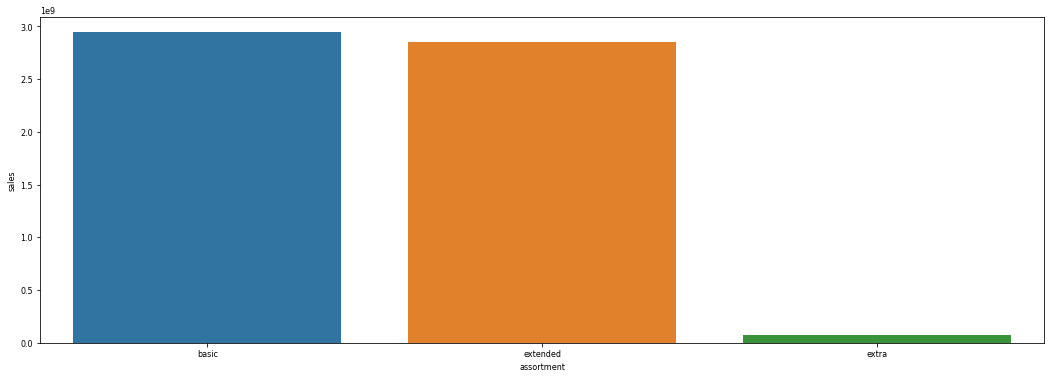

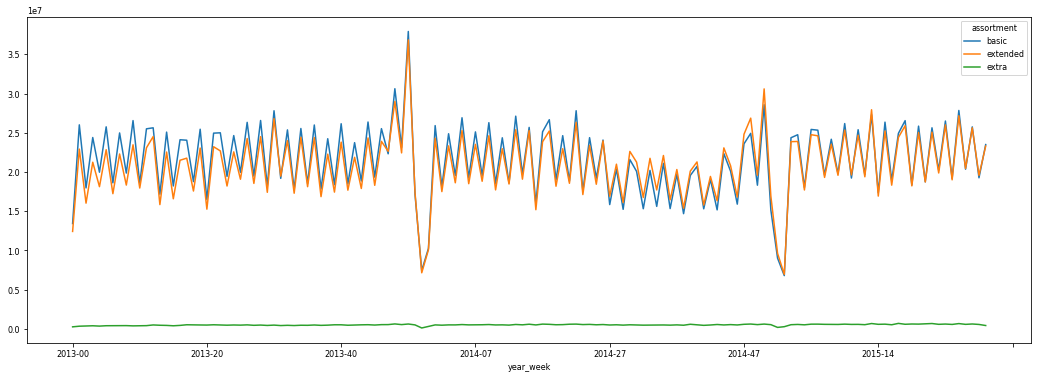

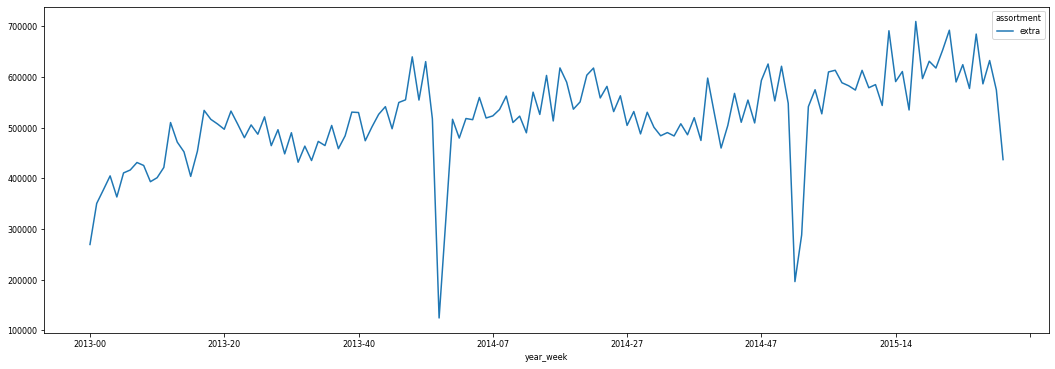

In [28]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux3 = aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

In [29]:
aux2.head()

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


In [30]:
aux3.head()

,year_week,assortment,sales
2,2013-00,extra,269404
5,2013-01,extra,350279
8,2013-02,extra,377207
11,2013-03,extra,404662
14,2013-04,extra,363061


### **2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSO** Lojas com competidores mais próximos vendem MAIS

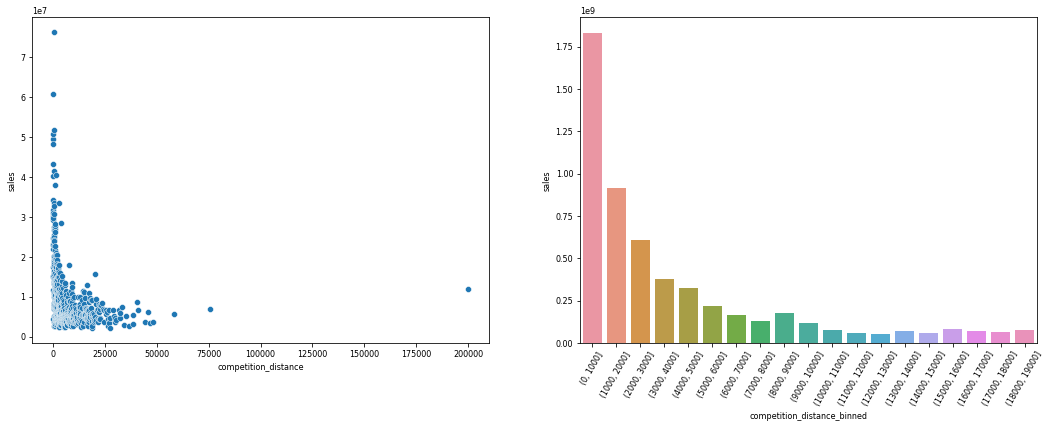

In [31]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,2,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,2,2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=60);

### **3.** Lojas com competidores há mais tempo deveriam vendem mais.
**FALSO** Lojas com competidores há mais tempo vendem MENOS

<AxesSubplot:>

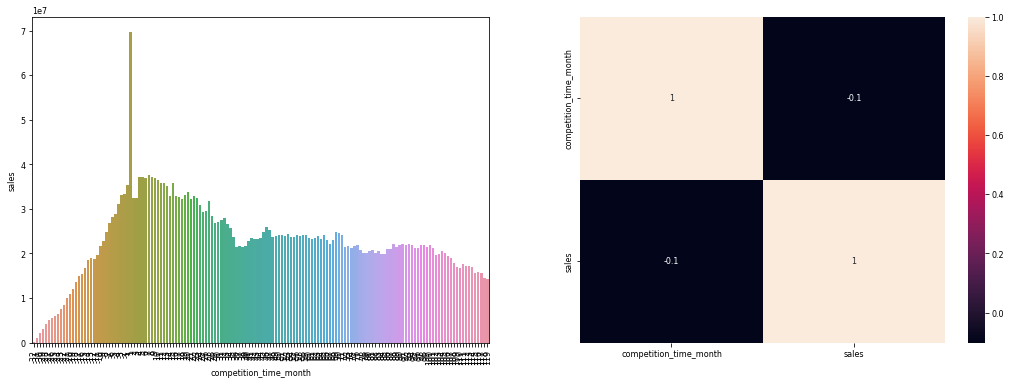

In [32]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

plt.subplot(1,2,1)
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,2,2)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSO** Lojas com promoções ativas pro mais tempo vendem MENOS depois de um certo período de promoção.

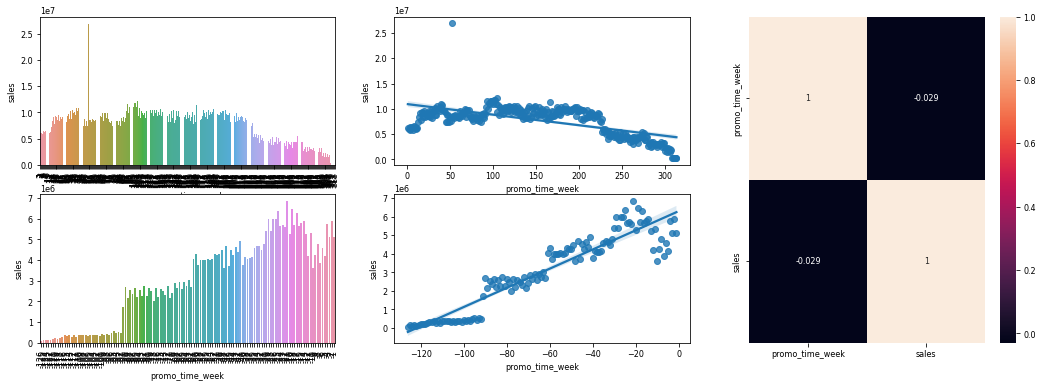

In [33]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0]   # promo extandida
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0]   # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>**5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas vendem MENOS

In [34]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


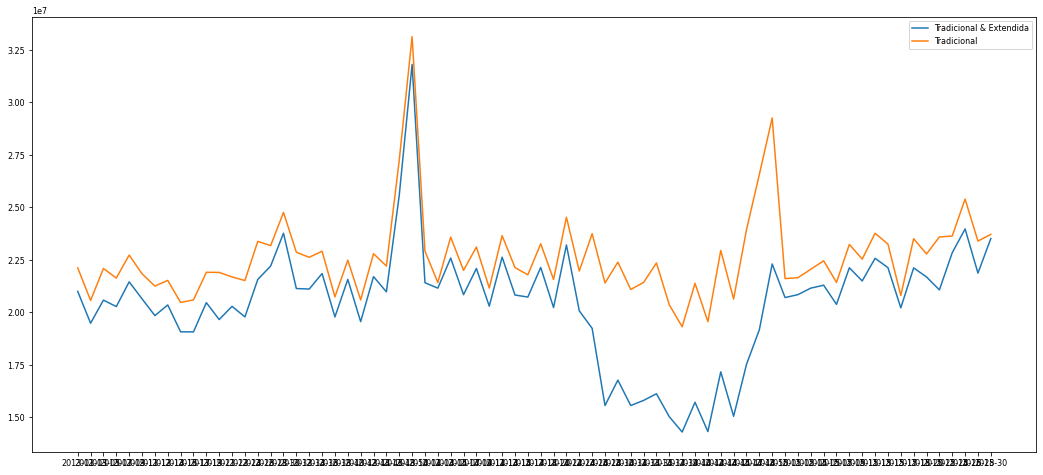

In [35]:
cols = ['year_week', 'sales']

lines = (df4['promo'] == 1) & (df4['promo2'] == 1)
aux1 = df4.loc[lines, cols].groupby('year_week').sum().reset_index()

lines = (df4['promo'] == 1) & (df4['promo2'] == 0)
aux2 = df4.loc[lines, cols].groupby('year_week').sum().reset_index()

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(aux1['year_week'], aux1['sales'], label='Tradicional & Extendida')
ax.plot(aux2['year_week'], aux2['sales'], label='Tradicional')
ax.legend()

In [36]:
aux1

,year_week,sales
0,2013-01,20995409
1,2013-03,19481514
2,2013-05,20580811
3,2013-07,20273185
4,2013-09,21451952
...,...,...
67,2015-22,21069133
68,2015-24,22839486
69,2015-26,23972605
70,2015-28,21867757


### **7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSO** Lojas abertas no Natal vendem MENOS

<AxesSubplot:xlabel='year', ylabel='sales'>

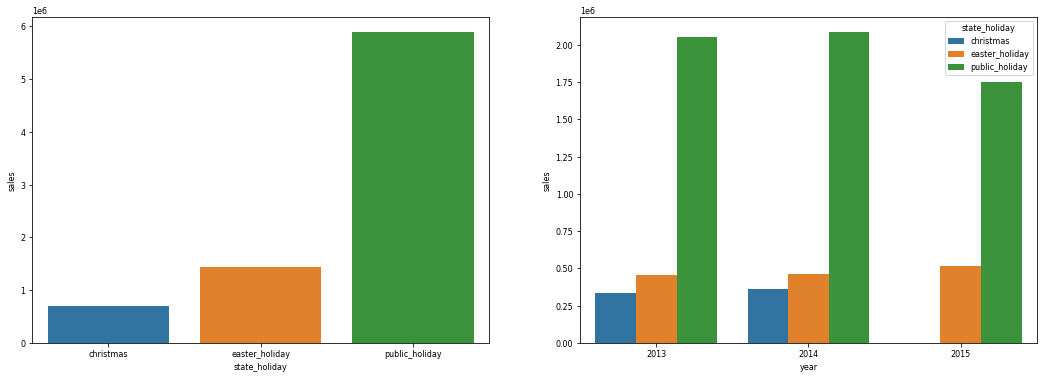

In [37]:
lines = (df4['state_holiday'] != 'regular_day')

cols1 = ['state_holiday', 'sales']
aux1 = df4.loc[lines, cols1].groupby('state_holiday').sum().reset_index()

cols2 = ['year', 'state_holiday', 'sales']
aux2 = df4.loc[lines, cols2].groupby(['year', 'state_holiday']).sum().reset_index()

fig, ax = plt.subplots(1,2)
sns.barplot(ax=ax[0], data=aux1, x='state_holiday', y='sales')
sns.barplot(ax=ax[1], data=aux2, x='year', y='sales', hue='state_holiday')
#ax[0].bar(aux1['state_holiday'], aux1['sales'])
#ax[1].bar(aux2['year'], aux2['sales'])



In [38]:
aux2.head()

,year,state_holiday,sales
0,2013,christmas,331182
1,2013,easter_holiday,454997
2,2013,public_holiday,2052408
3,2014,christmas,360624
4,2014,easter_holiday,463353


### **8.** Lojas deveriam vender mais ao longo dos anos.
**FALSO** Lojas vendem menos ao longo dos anos

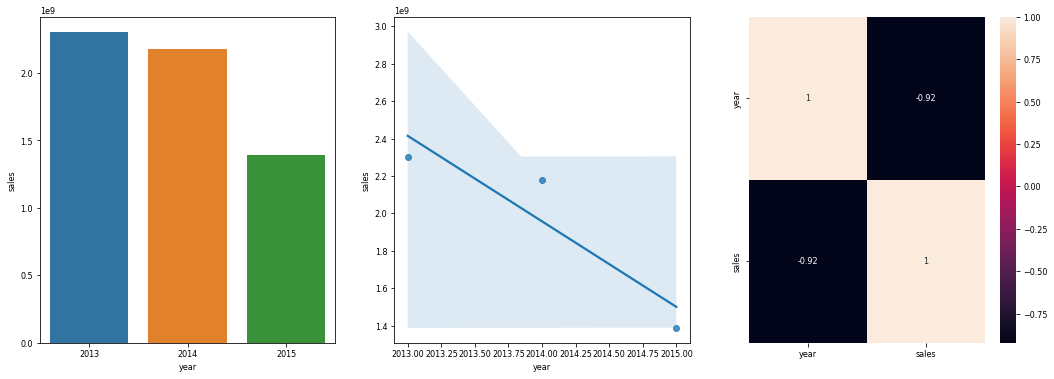

In [39]:
#lines = (df4['state_holiday'] != 'regular_day')

cols1 = ['year', 'sales']
aux1 = df4.loc[:, cols1].groupby('year').sum().reset_index()

fig, ax = plt.subplots(1,3)
sns.barplot(ax=ax[0], data=aux1, x='year', y='sales')
sns.regplot(ax=ax[1], data=aux1, x='year', y='sales')
sns.heatmap(aux1.corr(method='pearson'), ax=ax[2], annot=True);

### **9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSO** Lojas vendem menos no segundo semestre do ano

<AxesSubplot:>

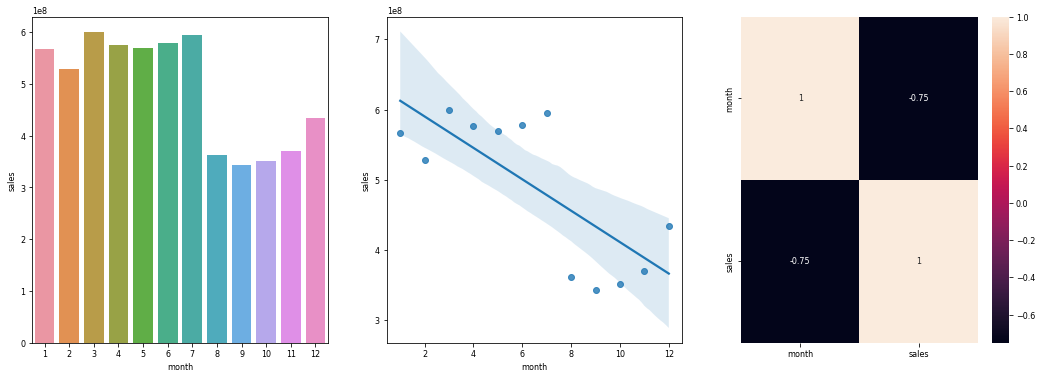

In [40]:
cols1 = ['month', 'sales']
aux1 = df4.loc[:, cols1].groupby('month').sum().reset_index()

fig, ax = plt.subplots(1,3)
sns.barplot(ax=ax[0], data=aux1, x='month', y='sales')
sns.regplot(ax=ax[1], data=aux1, x='month', y='sales')
sns.heatmap(aux1.corr(method='pearson'), ax=ax[2], annot=True)

### **10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADE** Lojas vendem mais após o dia 10 de cada mês

<AxesSubplot:>

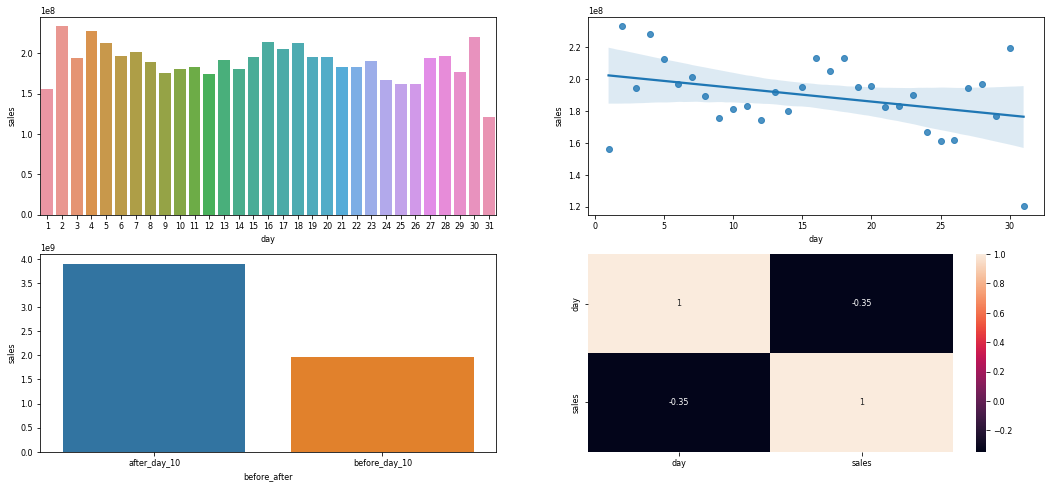

In [41]:
cols1 = ['day', 'sales']
aux1 = df4.loc[:, cols1].groupby('day').sum().reset_index()
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_day_10' if x <= 10 else 'after_day_10')

cols2 = ['before_after', 'sales']
aux2 = aux1.loc[:, cols2].groupby('before_after').sum().reset_index()

fig, ax = plt.subplots(2,2, figsize=(18,8))
sns.barplot(ax=ax[0,0], data=aux1, x='day', y='sales')
sns.regplot(ax=ax[0,1], data=aux1, x='day', y='sales')
sns.barplot(ax=ax[1,0], data=aux2, x='before_after', y='sales')
sns.heatmap(aux1[cols1].corr(method='pearson'), ax=ax[1,1], annot=True)

### **11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA**

<AxesSubplot:>

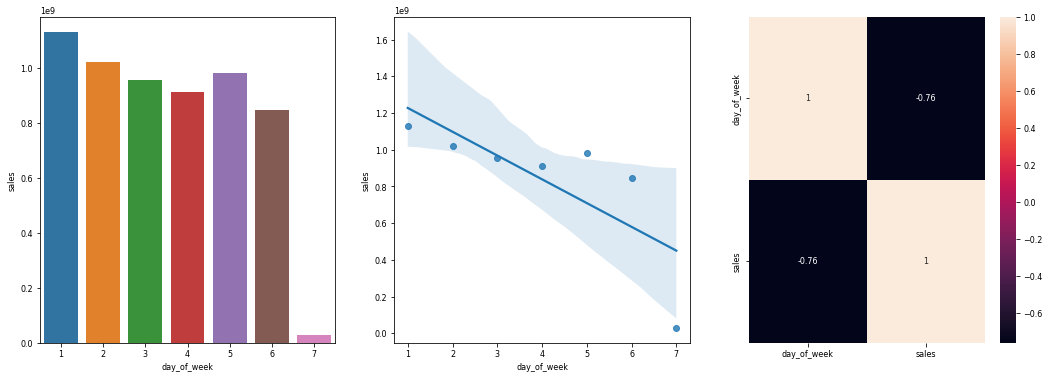

In [42]:
cols1 = ['day_of_week', 'sales']
aux1 = df4.loc[:, cols1].groupby('day_of_week').sum().reset_index()

fig, ax = plt.subplots(1,3)
sns.barplot(ax=ax[0], data=aux1, x='day_of_week', y='sales')
sns.regplot(ax=ax[1], data=aux1, x='day_of_week', y='sales')
sns.heatmap(aux1.corr(method='pearson'), ax=ax[2], annot=True)

### **12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRO** Exceto em Julho e Agosto

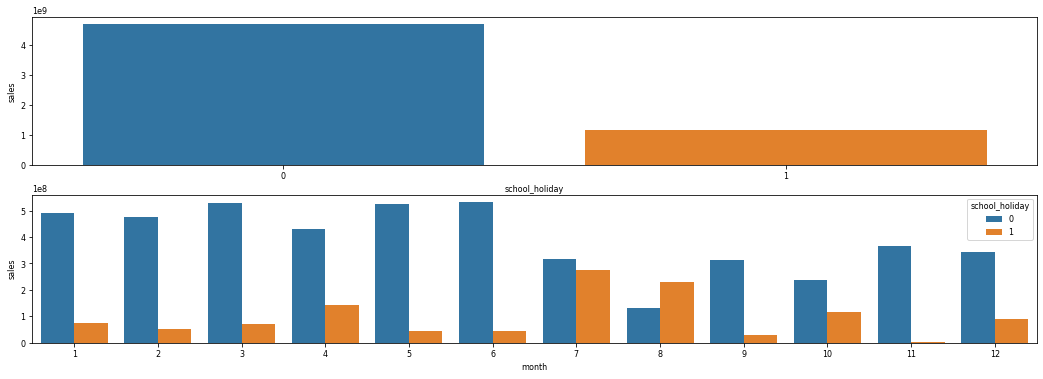

In [43]:
cols1 = ['school_holiday', 'sales']
aux1 = df4.loc[:, cols1].groupby('school_holiday').sum().reset_index()

cols2 = ['month', 'school_holiday', 'sales']
aux2 = df4.loc[:, cols2].groupby(['month', 'school_holiday']).sum().reset_index()

fig, ax = plt.subplots(2,1)
sns.barplot(ax=ax[0], data=aux1, x='school_holiday', y='sales')
sns.barplot(ax=ax[1], data=aux2, x='month', y='sales', hue='school_holiday');

## 4.3. Análise Multivariada

### 4.3.1. Numerical Attributes

<AxesSubplot:>

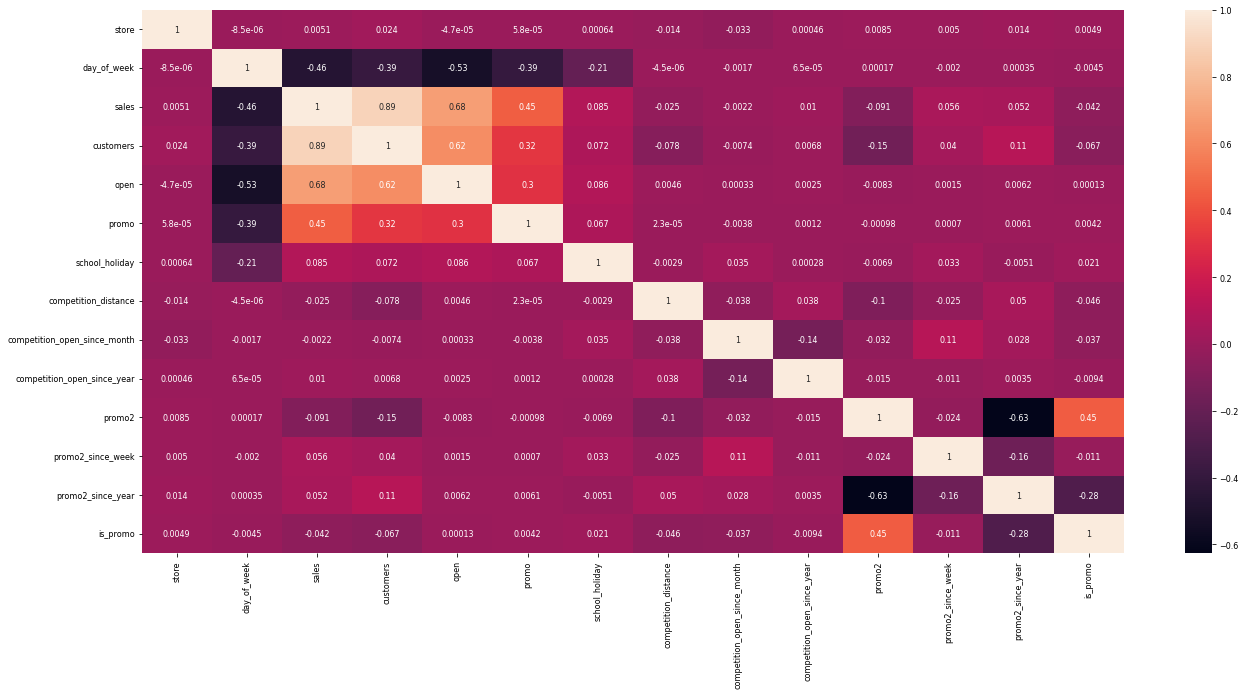

In [51]:
correlation = num_attributes.corr(method='pearson')

plt.figure(figsize=(22,10))
sns.heatmap(correlation, annot=True)

### 4.3.2. Categorical Attributes

In [69]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    phi2 = chi2 / n
    tilde_phi2 = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    tilde_k = k - (k - 1)**2 / (n - 1)
    tilde_r = r - (r - 1)**2 / (n - 1)
    return np.sqrt((tilde_phi2) / (min(tilde_k-1, tilde_r-1)))

<AxesSubplot:>

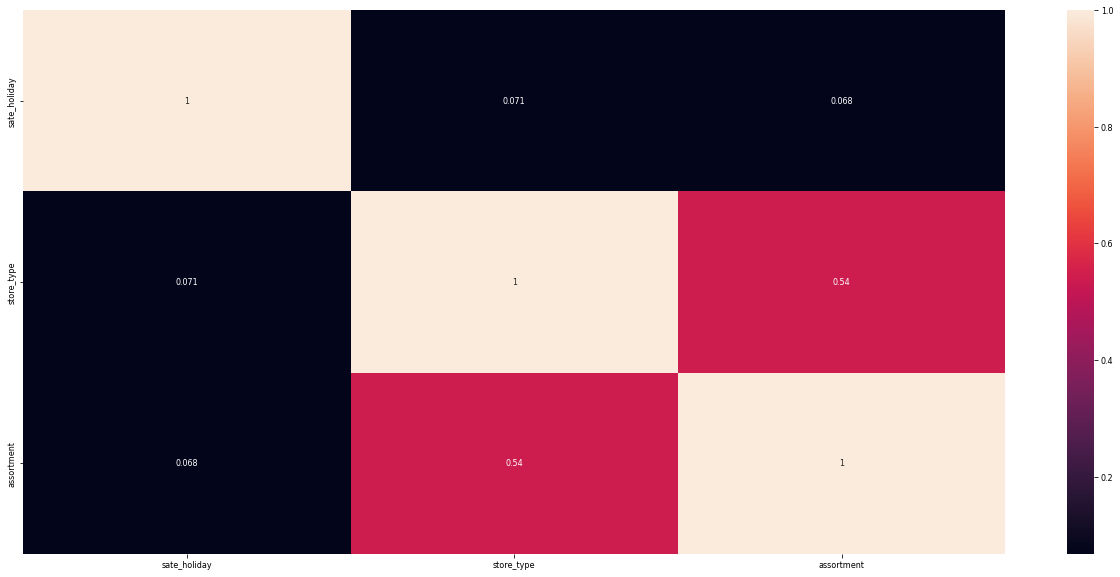

In [75]:
# Only cat attributes
aux1 = df4.select_dtypes(include='object')

a1 = cramer_v(aux1['state_holiday'], aux1['state_holiday'])
a2 = cramer_v(aux1['state_holiday'], aux1['store_type'])
a3 = cramer_v(aux1['state_holiday'], aux1['assortment'])

a4 = cramer_v(aux1['store_type'], aux1['state_holiday'])
a5 = cramer_v(aux1['store_type'], aux1['store_type'])
a6 = cramer_v(aux1['store_type'], aux1['assortment'])

a7 = cramer_v(aux1['assortment'], aux1['state_holiday'])
a8 = cramer_v(aux1['assortment'], aux1['store_type'])
a9 = cramer_v(aux1['assortment'], aux1['assortment'])

d = pd.DataFrame({'sate_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

plt.figure(figsize=(22,10))
sns.heatmap(d, annot=True)